In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from tqdm import tqdm_notebook as tqdm
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [2]:
SMALL_DATASET_DIR = '../lab1/notMNIST_small/'
LARGE_DATASET_DIR = '../lab1/notMNIST_large/'

In [3]:
def read(data_dir):
    X, y = [], []
    for f in tqdm(os.listdir(data_dir), desc='Loading letters'):
        print(f'Letter: {f}')
        if not f.startswith('.'):
            img_dir = os.path.join(data_dir, f)
            for img in os.listdir(img_dir):
                img_path = os.path.join(img_dir, img)
                data = cv2.imread(img_path, 0)

                if data is None:
                    continue
                assert(data.shape == (28, 28))
                x_samples = data.reshape((28*28,))
                X.append(x_samples)
                y.append(f)
    
    X = np.array(X, dtype='uint8')
    y = np.array(y)
    
    return X, y

In [4]:
X, y = read(SMALL_DATASET_DIR)

Letter: A
Letter: B
Letter: C
Letter: D
Letter: E
Letter: F
Letter: G
Letter: H
Letter: I
Letter: J



In [5]:
X.shape, y.shape

((18724, 784), (18724,))

In [6]:
def get_split_data(data_dir, size=(0.038, 10000, 200000), random_state=23):
    X, y = read(data_dir)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                      test_size=size[1], 
                                                      train_size=size[2],
                                                      random_state=random_state, 
                                                      shuffle=True)
     
    return X_train, y_train, X_val, y_val 

In [13]:
X_train, y_train, X_val, y_val = get_split_data(LARGE_DATASET_DIR)


Letter: A
Letter: B
Letter: C
Letter: D
Letter: E
Letter: F
Letter: G
Letter: H
Letter: I
Letter: J



In [18]:
def get_test_data(data_dir, size=(0.2, 18723, 10000), random_state=23):
    X, y = read(data_dir)    
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                       test_size=size[1], 
                                                       random_state=random_state, 
                                                       shuffle=True)
    
    return X_test, y_test

In [19]:
X_test, y_test = get_test_data(SMALL_DATASET_DIR)

Letter: A
Letter: B
Letter: C
Letter: D
Letter: E
Letter: F
Letter: G
Letter: H
Letter: I
Letter: J



In [20]:
def plot_hist(values):
    pd.Series(values).value_counts().plot(kind='bar')

Train:
(200000, 784) (200000,)


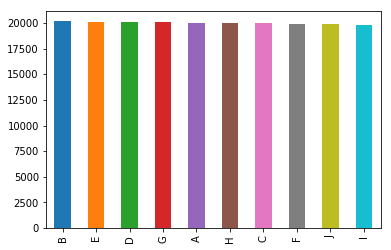

In [21]:
print('Train:')
print(X_train.shape, y_train.shape)
plot_hist(y_train)

Val:
(10000, 784) (10000,)


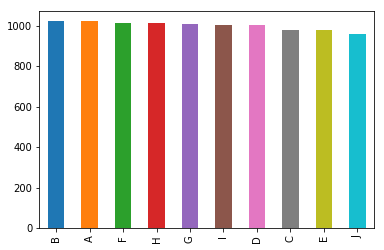

In [22]:
print('Val:')
print(X_val.shape, y_val.shape)
plot_hist(y_val)

Test:
(18723, 784) (18723,)


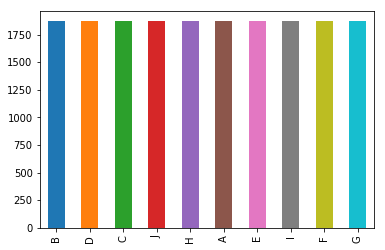

In [23]:
print('Test:')
print(X_test.shape, y_test.shape)
plot_hist(y_test)

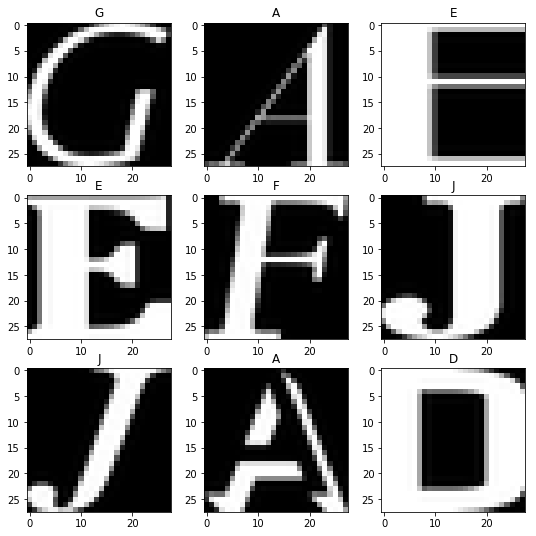

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i][j].set_title(y_test[idx][0])
        ax[i][j].imshow(np.array(X_test[idx]).reshape((28, 28)), cmap='gray')

In [25]:
def try_classifier(X_train, y_train, X_test, y_test, **params):
    classifier = LogisticRegression(solver='sag', #'lbfgs', 
                                    multi_class='multinomial', #ovr
                                    n_jobs=10, 
                                    random_state=23, 
                                    **params)
    classifier.fit(X_train, y_train)
    return classifier, classifier.score(X_test, y_test)

def try_different(**params):
    val_scores = []
    test_scores = []
    clfs = []
    
    train_sizes = np.linspace(5000, X_train.shape[0], 10)
    
    for N in tqdm(train_sizes):
        N = int(N)
        printmd(f'**Classifying {N} samples**')
        N_val = X_val.shape[0] * N // X_train.shape[0]
        print('Train:', N)
        print('Val:', N_val)
        clf, score = try_classifier(X_train[:N], 
                                    y_train[:N], 
                                    X_val[:N_val], 
                                    y_val[:N_val], 
                                    **params)
        val_scores.append(score)
        N_test = X_test.shape[0] * N // X_train.shape[0]
        print('Test:', N_test)
        test_score = clf.score(X_test[:N_test], y_test[:N_test])
        test_scores.append(test_score)
        print(f'valid score: {score},  test score: {test_score}')
        del clf
        
    return clfs, train_sizes, val_scores, test_scores

In [26]:
def viz_clf(clfs, train_sizes, val_scores, test_scores):
    plt.title('Validation and Hold out scores for N train samples')
    plt.xlabel('N')
    plt.ylabel('Score')
    plt.plot(train_sizes, val_scores, color='green', label='valid')
    plt.plot(train_sizes, test_scores, color='blue', label='hold out')
    plt.legend()
    plt.show()

In [29]:
def printmd(string):
    display(Markdown(string))

clfs, train_sizes, val_scores, test_scores = try_different(max_iter=10)
print(np.max(val_scores))
print(np.max(test_scores))

**Classifying 5000 samples**

Train: 5000
Val: 250


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 468
valid score: 0.828,  test score: 0.8675213675213675


**Classifying 26666 samples**

Train: 26666
Val: 1333


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 2496
valid score: 0.8267066766691673,  test score: 0.8994391025641025


**Classifying 48333 samples**

Train: 48333
Val: 2416


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 4524
valid score: 0.8249172185430463,  test score: 0.8974358974358975


**Classifying 70000 samples**

Train: 70000
Val: 3500


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 6553
valid score: 0.8265714285714286,  test score: 0.893026094918358


**Classifying 91666 samples**

Train: 91666
Val: 4583


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 8581
valid score: 0.8284966179358498,  test score: 0.8956998018878919


**Classifying 113333 samples**

Train: 113333
Val: 5666


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 10609
valid score: 0.8295093540416519,  test score: 0.8979168630408144


**Classifying 135000 samples**

Train: 135000
Val: 6750


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 12638
valid score: 0.830962962962963,  test score: 0.8971356227251147


**Classifying 156666 samples**

Train: 156666
Val: 7833


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 14666
valid score: 0.8318651857525852,  test score: 0.898199918178099


**Classifying 178333 samples**

Train: 178333
Val: 8916


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 16694
valid score: 0.8291834903544191,  test score: 0.8973882832155265


**Classifying 200000 samples**

Train: 200000
Val: 10000


c:\users\yana.kenda\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test: 18723
valid score: 0.8298,  test score: 0.8977193825775783

0.8318651857525852
0.8994391025641025


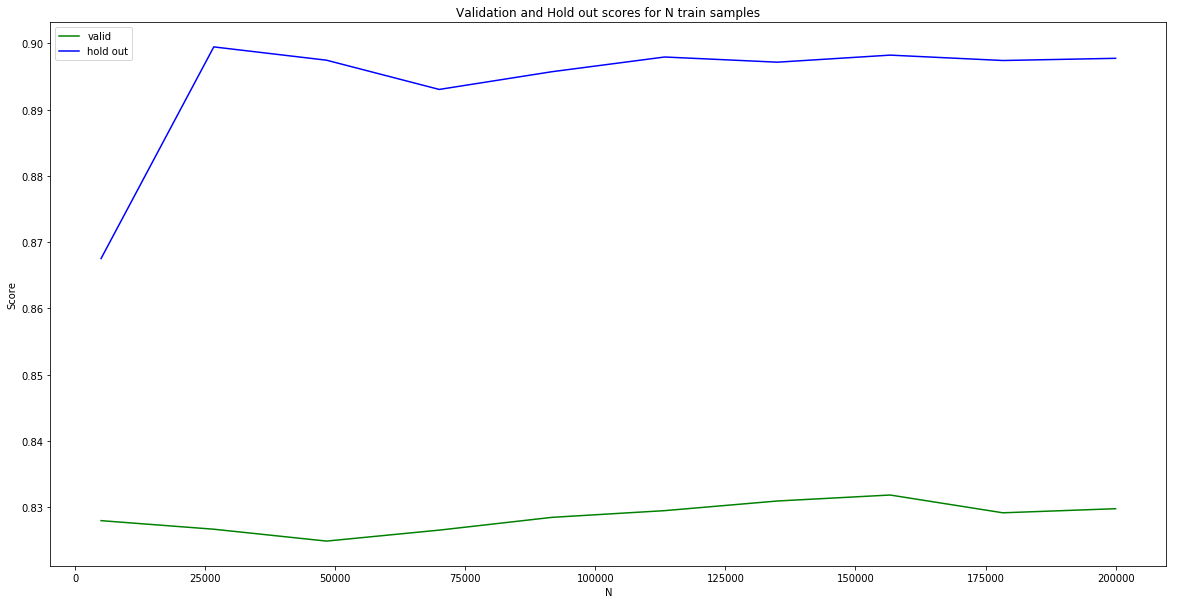

In [30]:
plt.figure(figsize=(20, 10))
viz_clf(clfs, train_sizes, val_scores, test_scores)